# ToO Secondary Targeting

Parse a set of target-of-opportunity observations created using the script

`/path/to/timedomain/bin/td_from_program TOO > too_tgt.out`

In [9]:
import os
from astropy.io import ascii, fits
from astropy.table import join, hstack, vstack, unique, Table
from desispec.spectra import stack as specstack
from desispec.io import read_spectra, write_spectra

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [10]:
mpl.rc('font', size=16)
mpl.rc('axes', titlesize='small')

## Load ToO Target SQLite DB

In [11]:
import sqlite3
from contextlib import closing

In [12]:
query = "SELECT DISTINCT mtl.targetid, f.target_ra, f.target_dec, f.yyyymmdd, f.tile, f.petal \
         FROM mtl INNER JOIN fibermap_daily AS f \
         ON mtl.targetid==f.targetid \
         WHERE mtl.program='ToO';"

# query = 'SELECT m.PROGRAM, m.TARGETID, m.RA, m.DEC, s.NIGHT, s.EXPID, s.TILEID, s.FIBER, s.PETAL_LOC \
#                    FROM mtl as m \
#                    JOIN spectra as s on S.TARGETID = m.TARGETID \
#                    ORDER BY m.TARGETID ASC, s.NIGHT;'

with closing(sqlite3.connect('/global/cfs/cdirs/desi/science/td/db/desi.db')) as db:
    with closing(db.cursor()) as cursor:
        rows = cursor.execute(query).fetchall()

In [16]:
too_targets = Table(list(map(list, zip(*rows))),
#                     names=['PROGRAM', 'TARGETID', 'TARGET_RA', 'TARGET_DEC', 'DATE', 'EXPID', 'TILEID', 'FIBER', 'PETAL'])
                    names=['TARGETID', 'TARGET_RA', 'TARGET_DEC', 'DATE', 'TILEID', 'PETAL'])
too_targets['PROGRAM'] = 'ToO'
too_targets

TARGETID,TARGET_RA,TARGET_DEC,DATE,TILEID,PETAL,PROGRAM
int64,float64,float64,int64,int64,int64,str3
43977450371153935,219.698146,-0.134828,20210503,262,5,ToO
43977450371153935,219.698146,-0.134828,20210502,262,5,ToO
43977456419340308,220.147675,0.051003,20210503,262,6,ToO
43977456419340308,220.147675,0.051003,20210502,262,6,ToO
43977414082035733,216.688787,-1.861117,20210503,225,0,ToO
43977516771180576,217.259658,2.561925,20210430,287,3,ToO
43977432176263222,215.01975,-1.029686,20210503,232,2,ToO
43977444352327746,220.7983,-0.4306,20210503,262,7,ToO
43977444352327746,220.7983,-0.4306,20210502,262,7,ToO


In [17]:
def plot_radec(table):
    """Mollweide projection plot adapted to astro coordinates.
    
    Parameters
    ----------
    table : astropy.table.Table
        Data table with secondary target info.
    
    Returns
    -------
    fig : matplotlib.Figure
        Figure object to let user apply further plot manipulation.
    """
    fig, ax = plt.subplots(1,1, figsize=(8,4), subplot_kw={'projection': 'mollweide'})
    
    # Loop through unique classes.
    class_names = np.unique(table['PROGRAM'])
    for class_name in class_names:
        select = table['PROGRAM'] == class_name
        
        # Convert RA, Dec to radians.
        # Rotate the RA so that the plot goes 360->0 left to right.
        _ra = np.radians(180. - table[select]['TARGET_RA'])
        _dec = np.radians(table[select]['TARGET_DEC'])
        ax.scatter(_ra, _dec, alpha=0.5, s=5, label=class_name)

    # Clean up the plot and return the Figure object.
    ax.set(xticks=np.radians([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150]),
           xticklabels=['22h', '20h', '18h', '16h', '14h', '12h', '10h', '8h', '6h', '4h', '2h'])
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(ls=':')
    
    ax.legend(fontsize=8, loc='lower right')
    fig.tight_layout()

    return fig;

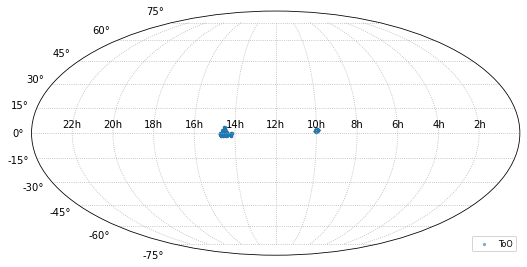

In [18]:
fig = plot_radec(too_targets)

## Extract Object Redshifts

For each object in the table, extract the redshift.

In [19]:
tile_date_petal = []

for too_target in too_targets:
    tdp = [too_target[_] for _ in ['TILEID', 'DATE', 'PETAL']]
    if tdp in tile_date_petal:
        continue
    tile_date_petal.append(tdp)

In [20]:
redux = 'daily'

toospec = None

n = 0

for i, (tile, date, petal) in enumerate(tile_date_petal):
    select = (too_targets['TILEID']==tile) & (too_targets['DATE']==date) & (too_targets['PETAL']==petal)
    n += np.sum(select)
    targetids = too_targets[select]['TARGETID']
    
    folder = '{}/{}/tiles/{}/{}'.format(os.environ['DESI_SPECTRO_REDUX'], redux, tile, date)
    cdfile = '{}/coadd-{}-{}-{}.fits'.format(folder, petal, tile, date)
    zbfile = '{}/zbest-{}-{}-{}.fits'.format(folder, petal, tile, date)
    
    if os.path.exists(zbfile) and os.path.exists(cdfile):
        spectra = read_spectra(cdfile)
        
        # Select matching target IDs from the ToO list and read out ToO spectra.
        sselect = np.in1d(spectra.fibermap['TARGETID'], targetids)
        spectra = spectra[sselect]
        if not hasattr(spectra, 'scores_comments'):
            spectra.scores_comments = None
        
        # Select matching target IDs from the ToO list and access the redshift fit.
        zbest = fits.open(zbfile)['ZBEST'].data
        zselect = np.in1d(zbest['TARGETID'], targetids)
        zbest = zbest[zselect]
        
        # Append spectra to a larger list of spectra, stored in memory.
        # Note that an EXPID is required in the update step below, but the coadded spectra
        # have a FIRST_EXPID and a LAST_EXPID. So copy one of these as a hack.
        spectra.fibermap['EXPID'] = spectra.fibermap['LAST_EXPID']
        spectra.extra_catalog = zbest
        
        if toospec is None:
            toospec = spectra
        else:
            toospec = specstack([toospec, spectra])
        
        if (i+1) % 10 == 0:
            print('{} out of {}; ({} {})'.format(i+1, len(tile_date_petal), n, toospec.num_spectra()))
            
if not hasattr(toospec, 'scores_comments'):
    toospec.scores_comments = None

INFO:spectra.py:253:read_spectra: iotime 0.815 sec to read coadd-5-262-20210502.fits at 2021-05-26T11:47:16.619397
INFO:spectra.py:253:read_spectra: iotime 0.894 sec to read coadd-6-262-20210502.fits at 2021-05-26T11:47:18.047270
INFO:spectra.py:253:read_spectra: iotime 0.713 sec to read coadd-0-225-20210503.fits at 2021-05-26T11:47:19.400188
INFO:spectra.py:253:read_spectra: iotime 0.760 sec to read coadd-3-287-20210430.fits at 2021-05-26T11:47:20.771254
INFO:spectra.py:253:read_spectra: iotime 0.797 sec to read coadd-7-262-20210502.fits at 2021-05-26T11:47:22.123521
INFO:spectra.py:253:read_spectra: iotime 0.811 sec to read coadd-7-261-20210430.fits at 2021-05-26T11:47:23.562872
10 out of 197; (25 14)
INFO:spectra.py:253:read_spectra: iotime 0.713 sec to read coadd-2-288-20210502.fits at 2021-05-26T11:47:24.899705
INFO:spectra.py:253:read_spectra: iotime 0.805 sec to read coadd-2-287-20210430.fits at 2021-05-26T11:47:26.405763
INFO:spectra.py:253:read_spectra: iotime 0.818 sec to rea

In [21]:
toospec.num_spectra()

367

### Output Redrock Spectral Types

In [22]:
types_, counts_ = np.unique(toospec.extra_catalog['SPECTYPE'], return_counts=True)
for t, c in zip(types_, counts_):
    print('{:10s} : {:10d} ({:.1f}%)'.format(t, c, 100*c/len(toospec.extra_catalog)))

b'GALAXY'  :        319 (86.9%)
b'QSO'     :         18 (4.9%)
b'STAR'    :         30 (8.2%)


## Write Output

### FITS Format

This format is needed to preserve the redrock template coefficients in the output, should they be needed for spectral matching and plotting later.

**WARNING**: the output file will *always* be clobbered so proceed with caution!

In [23]:
write_spectra('too_redshifts.fits', toospec)

INFO:spectra.py:154:write_spectra: iotime 1.621 sec to write too_redshifts.fits at 2021-05-26T11:49:33.437843


'/global/u2/s/sybenzvi/desi/timedomain/db/too_redshifts.fits'

## Plot Spectra

Probably should pull in `plot_spectra` here but it's easy to write some code too.

### Grab Legacy Survey Cutouts

Some code to access legacy survey cutouts.

In [24]:
import requests

def get_cutout(targetid, ra, dec, verbose=False):
    """Grab and cache legacy survey cutouts.
    
    Parameters
    ----------
    targetid : int
        DESI target ID.
    ra : float
        Right ascension (degrees).
    dec : float
        Declination (degrees).
    verbose : bool
        Add some status messages if true.
        
    Returns
    -------
    img_name : str
        Name of JPG cutout file written after query.
    """
    img_name = '{}.jpg'.format(targetid)
    
    if os.path.exists(img_name):
        if verbose:
            print('{} exists.'.format(img_name))
    else:
        if verbose:
            print('Accessing {}'.format(img_name))
        img_url = 'https://www.legacysurvey.org/viewer/cutout.jpg?ra={}&dec={}&%22/pix=0.25&layer=dr8&size=180'.format(ra, dec)
        with open(img_name, 'wb') as handle: 
            response = requests.get(img_url, stream=True) 
            if not response.ok: 
                print(response) 
            for block in response.iter_content(1024): 
                if not block: 
                    break 
                handle.write(block)
    
    return img_name

#### Spectrum Plot Options

Pull in a basic Gaussian smoothing filter and some code for plotting the same emission and absorption features used in Prospect.

In [25]:
from scipy.ndimage import gaussian_filter1d

mpl.rc('figure', max_open_warning = 0)

In [26]:
# Emission and absorption lines from Prospect tables.
emi_lines = ascii.read('emission_lines.txt', comment='#', names=['name','longname','lambda','vacuum','major'])
abs_lines = ascii.read('absorption_lines.txt', comment='#', names=['name','longname','lambda','vacuum','major'])

emi_lines_major = emi_lines[emi_lines['major']=='True']
abs_lines_major = abs_lines[abs_lines['major']=='True']

In [27]:
for i in range(toospec.num_spectra()):
    
    fig, axes = plt.subplots(1,2, figsize=(16,5), gridspec_kw={'width_ratios':[3,1.1]},
                             tight_layout=True)
    
    # Plot the spectra.
    ax = axes[0]
    
    fmin, fmax = 1e99, -1e99
    for band in 'brz':
        smoothed = gaussian_filter1d(toospec.flux[band][i], 5)
        fmin = np.minimum(fmin, np.min(smoothed))
        fmax = np.maximum(fmax, np.max(smoothed))
        ax.plot(toospec.wave[band], smoothed)
        
    zbest = toospec.extra_catalog[i]
    z = zbest['Z']
    dchi2 = zbest['DELTACHI2']
    zwarn = zbest['ZWARN']
    sptype = zbest['SPECTYPE']
    print(dchi2, zwarn)
    
    for eline in emi_lines:
        wl = eline['lambda']*(1 + z)
        if wl > 3600 and wl < 9800:
            ax.axvline(wl, ls='--', color='k', alpha=0.3)
            ax.text(wl+20, fmin, eline['name'], fontsize=8, rotation=90, alpha=0.3)

    for aline in abs_lines:
        wl = aline['lambda']*(1 + z)
        if wl > 3600 and wl < 9800:
            ax.axvline(wl, ls='--', color='r', alpha=0.3)
            ax.text(wl+20, 0.95*fmax, aline['name'], color='r', fontsize=8, rotation=90, alpha=0.3)

    ax.set(xlabel=r'$\lambda_{\mathrm{obs}}$ [$\AA$]',
           xlim=(3500,9900),
           ylabel=r'flux [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]',
           title=r'{}; $z={:.3f}$ ($\Delta\chi^2={:.5g}$; ZWARN=0x{:x}; SPECTYPE={:s})'.format(toospec.fibermap[i]['TARGETID'], z, dchi2, zwarn, sptype.decode('utf-8')),
          )
    
    # Plot the image cutout.
    ax = axes[1]
    
    obj = toospec.fibermap[i]
    img_file = get_cutout(obj['TARGETID'], obj['TARGET_RA'], obj['TARGET_DEC'])
    img = mpl.image.imread(img_file)

    ax.imshow(img)

    x1, x2, x3, x4 = [90, 90], [70, 80], [90, 90], [100,110]
    y1, y2, y3, y4 = [70, 80], [90, 90], [100,110], [90,90]
    ax.plot(x1, y1, x2, y2, x3, y3, x4, y4, color='r', linewidth=2, alpha=0.7)
    ax.text(5,15, '{:3s} = {}\n{:3s} = {}'.format('RA', obj['TARGET_RA'], 'Dec', obj['TARGET_DEC']), color='yellow', fontsize=9)
    ax.set(aspect='equal',
           title='{}, Tile {}, Exp {}'.format(obj['LAST_NIGHT'], obj['TILEID'], obj['EXPID']))
    ax.axis('off')
    
    fig.savefig('spec_cutout_{}_{}_{:06d}_{:06d}.png'.format(obj['TARGETID'], obj['LAST_NIGHT'], obj['TILEID'], obj['EXPID']), dpi=100)
    
    # Clean up
    fig.clear()
    plt.close(fig)

44465.415835894644 0
5.938904417678714 4
209.8828234281391 0
224.46613352000713 0
38.05268892738968 0
14253.925100207329 0
733.1248748600483 0
12153.841884613037 0
336.49620988965034 0
268.0761479064822 0
7.289266616106033 4
170.59241210203618 0
565.2275831066072 0
168.55236833542585 0
125.07720686495304 0
24.976645476999693 0
43.945407435297966 0
157.49491879343987 0
34152.02326416969 0
732.9350130744278 0
534.0070537887514 0
184.84366993559524 0
1.151291511952877 4
1.942668892225729e+84 1570
13.795390754938126 0
2.6947931833565235 4
232.2339970767498 0
172.33605879545212 0
17.489578291773796 0
344.903795927763 0
1983.5530768632889 0
117.96832393109798 0
754.39191198349 0
12.413900388404727 0
6.927726082503796 4
267.7137500895187 0
24.326235383749008 0
5.854011074639857 4
376.77261312554583 0
5.088006847254292 4
1391.8651479259133 0
11.964028172194958 0
2.4464563080109656 4
16.74435305595398 0
1.942668892225729e+84 1570
0.7296255379915237 4
95.44407993555069 0
83.52232363820076 0
5.78

In [28]:
too_targets.write('desi_too.txt', format='ascii.commented_header', overwrite=True)